HALLOOOO

# Analysing Coastal Change with Landsat

This notebook is a simplified, worked example of analysing multiple years of
Landsat data to locate the coastline, and its change over time.

The original implementation of this algorithm was achieved by Geoscience Australia
and is available at [dea-costlines](https://github.com/geoscienceAustralia/dea-coastlines).
There is a new version, which is more generic available at
[coastlines](https://github.com/auspatious/coastlines).

## Requirements

The algorithm uses two fundameltal datasets, first, optical Earth observation data,
and Landsat is ideal, as it goes back over forty years. And second, is a tidal
model, which is used to annotate scenes with a tide height, and to filter
those scenes to just those in the middle of the tide range, therefore establishing
an 'average' coastline.

## Configuration and setup

First, we import libraries and tools that we need to run the analysis.

In [1]:
import os

from coastlines.utils import extract_contours, tide_cutoffs
from coastlines.vector import annual_movements, calculate_regressions
from dask.distributed import Client
from datacube import Datacube
from datacube.utils.masking import create_mask_value, valid_data_mask
from dea_tools.spatial import points_on_line
from dea_tools.plotting import display_map, rgb, xr_animation
from dea_tools.datahandling import mostcommon_crs
from eo_tides import pixel_tides
from ipyleaflet import basemaps
from odc.geo.geom import point
from odc.stac import configure_s3_access

### Set up our environment

We're going to access Landsat data from USGS using the Element-84 STAC API.

The `configure_s3_access` function will set up the environment for the requester
pays bucket on S3, which USGS shares data from. And we use Dask to lazy-load
data and run the computation in parallel.

In [2]:
# Tide data and config
tide_data_location = "~/jovyan/data/coastlines/tide_models"

# Configure AWS
os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

if "AWS_NO_SIGN_REQUEST" in os.environ:
    del os.environ["AWS_NO_SIGN_REQUEST"]

configure_s3_access(requester_pays=True)

# Connect to the Datacube
dc = Datacube(app="coastlines")

# Set up a dask client
dask_client = Client(n_workers=4, threads_per_worker=8)
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 32,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35271,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38125,Total threads: 8
Dashboard: http://127.0.0.1:45491/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:38897,


### Set up a study location

Configure a spatial location and a time range.

In [3]:
start_date = "2010"
end_date = "2025"
max_cloud_cover = 90  # Maximum cloud cover percentage

# Find a location you're interested in on Google Maps and copy the coordinates
# by right-clicking on the map and clicking the coordinates

lat_range = (-8.3463, -8.31713)
lon_range = (115.62202, 115.67076)

display_map(x=lon_range, y=lat_range)

### Find and load data

Search for Landsat scenes and load them into memory using Dask.

In [9]:
categories_to_mask_landsat = {
    "cloud": "high_confidence",
    "cloud_shadow": "high_confidence",
}

# Find and load Landsat datasets
landsat_datasets = dc.find_datasets(
    product=["ls5_c2l2_sr", "ls7_c2l2_sr", "ls8_c2l2_sr", "ls9_c2l2_sr"],
    time=(start_date, end_date),
    longitude=lon_range,
    latitude=lat_range,
    cloud_cover=(0, max_cloud_cover),
    collection_category="T1",  # Only include T1 quality data
)

# Identify the most common projection system in the input query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': (start_date, end_date),
    'resolution': (-30, 30),
}
output_crs = mostcommon_crs(dc=dc, product="ls8_c2l2_sr", query=query)


print(f"Found {len(landsat_datasets)} Landsat datasets")

data = dc.load(
    datasets=landsat_datasets,
    longitude=lon_range,
    latitude=lat_range,
    resolution=30,
    output_crs=output_crs,
    measurements=["red", "green", "blue", "nir08", "swir16", "qa_pixel"],
    group_by="solar_day",
    dask_chunks={"time": 1, "x": 520, "y": 520},
    resampling={
        "*": "cubic",
        "qa_pixel": "nearest",
    },
    # skip_broken_datasets=True,
    driver="rio",
)

Querying product Product(name='ls5_c2l2_sr', id_=4)
Querying product Product(name='ls7_c2l2_sr', id_=3)
Querying product Product(name='ls8_c2l2_sr', id_=2)
Querying product Product(name='ls9_c2l2_sr', id_=1)
Querying product Product(name='ls8_c2l2_sr', id_=2)


Found 330 Landsat datasets


### Preview data

This cell first selects the first four scenes using the `isel` or "index select" function.
And then plots that from an array, so that we get an RGB visualisation.

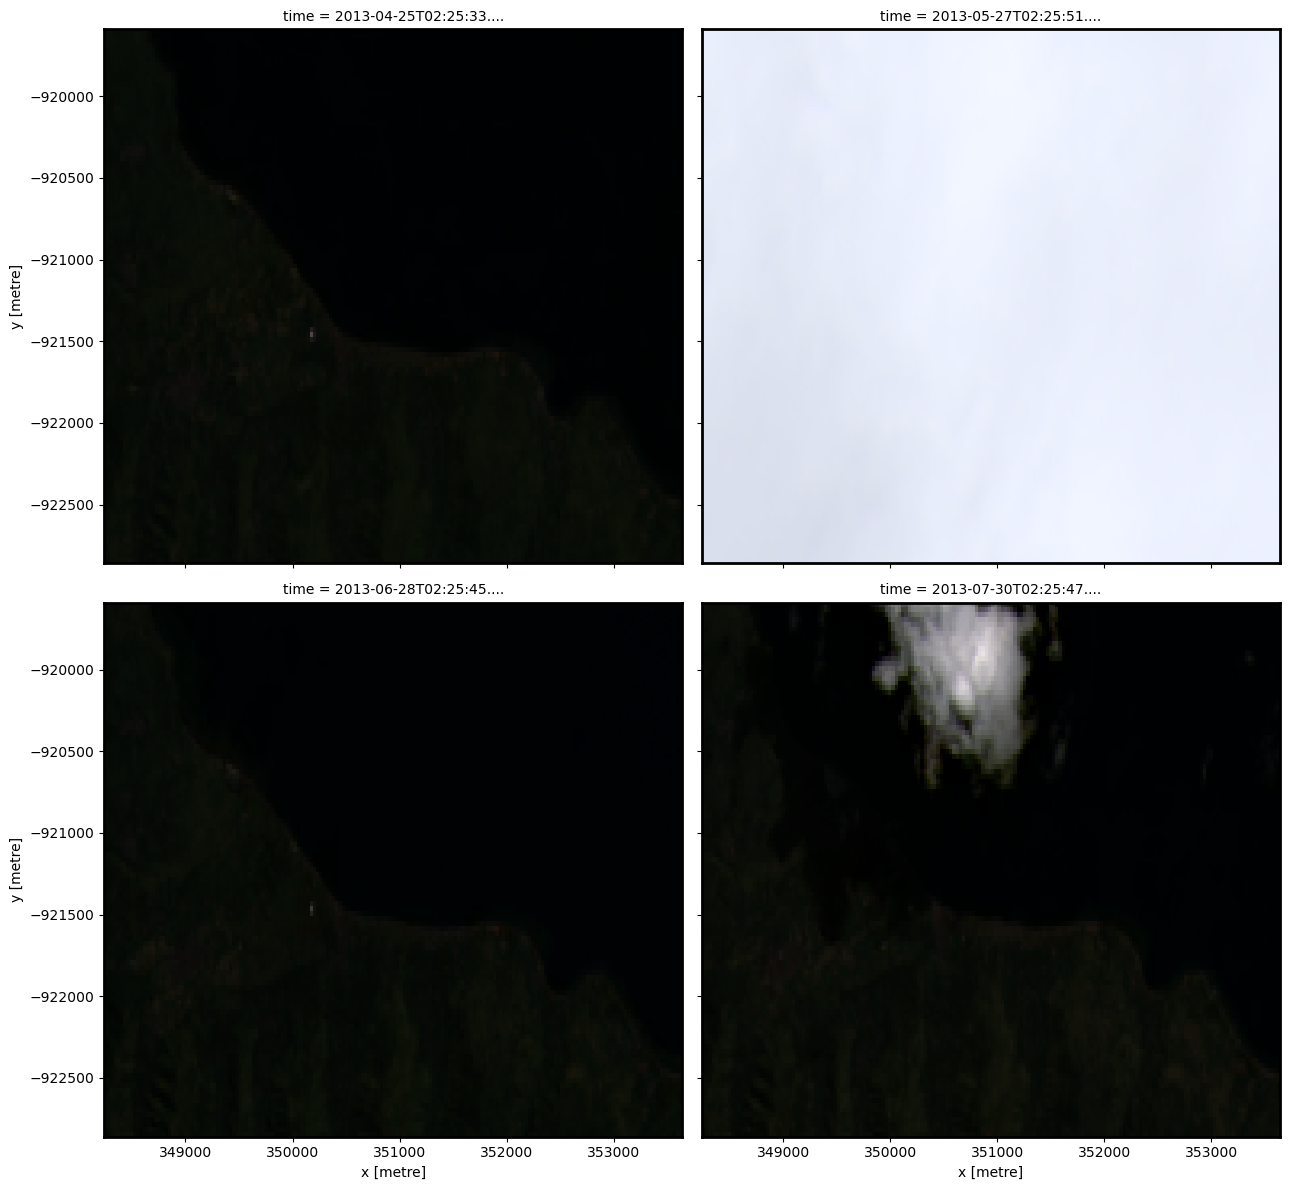

In [10]:
subset = data[["red", "green", "blue"]].isel(time=slice(0, 4))
subset.to_array().plot.imshow(col="time", col_wrap=2, size=6, robust=True)

## Data processing

Now we know we have some good data, we can start processing. First we need to mask
out clouds, so that they don't impact our results.

In [ ]:
# Mask Landsat data
mask_value, _ = create_mask_value(
    landsat_datasets[0].product.measurements["qa_pixel"].flags_definition,
    **categories_to_mask_landsat,
)

cloud_mask = (data.qa_pixel & mask_value) != 0
valid_data = valid_data_mask(data)
mask = cloud_mask | ~valid_data

masked = data.where(~mask).drop_vars("qa_pixel")

# Scale Landsat data, so that values are between 0 and 1
masked = (masked * 0.0000275 - 0.2).clip(0, 1)

masked

In [ ]:
# Preview the masked data
masked_subset = masked[["red", "green", "blue"]].isel(time=range(0, 4))
masked_subset.to_array().plot.imshow(col="time", col_wrap=2, size=6, robust=True)

### Tide masking

This cell filters out scenes that are wholy in the "extreme" tides, or those
outside the middle 50% of observations.

In [ ]:
# Add tide height to the data
tides = pixel_tides(
    masked,
    resample=True,
    directory=tide_data_location,
    model="FES2022",
    dask_compute=True,
)

# Determine tide cutoff
tide_cutoff_min, tide_cutoff_max = tide_cutoffs(data, tides, tide_centre=0.0)

tide_bool = (tides >= tide_cutoff_min) & (tides <= tide_cutoff_max)
data_filtered = masked.sel(time=tide_bool.sum(dim=["x", "y"]) > 0)

# Apply mask, and load in corresponding tide masked data
data_tide_masked = data_filtered.where(tide_bool)

data_tide_masked

### Identify land and water

We use a water index, here it's a combination of the normalised difference wetness index, NDWI,
and the modified version of that, MNDWI. We find the average of the two indices, which has been
found to be more robust to issues of noisy data over ocean in Landsat.

In [ ]:
# Create Combined index (the mean of MNDWI and NDWI)
# index_name = "combined"
# data_tide_masked["mndwi"] = (data_tide_masked.green - data_tide_masked.swir16) / (data_tide_masked.green + data_tide_masked.swir16)
# data_tide_masked["ndwi"] = (data_tide_masked.green - data_tide_masked.nir08) / (data_tide_masked.green + data_tide_masked.nir08)
# data_tide_masked["combined"] = (data_tide_masked.mndwi + data_tide_masked.ndwi) / 2

# # Create SCOWI index, which is an alternative to the above combined index
# index_name = "scowi"
# d = data_tide_masked
# data_tide_masked["scowi"] = d.blue + 2 * (d.green - d.nir08) - 0.75 * (d.swir16) - 0.5 * (d.swir16)

# # Create MNDWI_NIR index
index_name = "mndwi_nir"
scaled_green = (
    data_tide_masked.green
    + (data_tide_masked.nir08.max(dim="time") - data_tide_masked.nir08)
) / 2
scaled_swir1 = (data_tide_masked.swir16 + data_tide_masked.nir08) / 2
data_tide_masked["mndwi_nir"] = (scaled_green - scaled_swir1) / (
    scaled_green + scaled_swir1
)

grouped_by_year = (
    data_tide_masked[index_name]
    .groupby("time.year")
    .median()
    .to_dataset(name=index_name)
)
grouped_by_year = grouped_by_year.compute()

In [ ]:
grouped_by_year[index_name].plot.imshow(
    col="year", col_wrap=2, size=6, cmap="RdBu", robust=True
)

### Extract contours

Next we extract contour lines from the underlying land/water raster data.

In [ ]:
# You can also try using the other index above
# use z_value of 0.0 for 'mndwi'
# use z_value of 0.65 for `mndwi_nir`
z_values = 0.65

contour_gdf = extract_contours(
    grouped_by_year, z_values=z_values, index_name=index_name
)

contour_gdf.reset_index().explore(
    column="year",
    cmap="magma",
    style_kwds={"weight": 3},
    tiles=basemaps.Esri.WorldImagery,
)

### Extract points

And from the contours, we extract points, and annotate them with change over time, so that
we can document how much the coastline has eroded or accreted.

In [ ]:
# Extract points at every 30 metres along the most recent shoreline
points_gdf = points_on_line(contour_gdf, index=2023, distance=30)

# Calculate annual movements based on the points from above
points_gdf = annual_movements(
    points_gdf,
    contours_gdf=contour_gdf,
    yearly_ds=grouped_by_year,
    baseline_year=2023,
    water_index=index_name,
)

# And regression lines
points_gdf = calculate_regressions(points_gdf=points_gdf)

## Visualisation

Finally, visualise the results together.

In [ ]:
# Add human-friendly label for plotting
points_gdf["Coastal change"] = points_gdf.apply(
    lambda x: f"<h4>This coastline has {'<b>retreated</b>' if x.rate_time < 0 else '<b>grown</b>'} "
    f"by</br><b>{x.rate_time:.2f} m (±{x.se_time:.1f}) per year</b> since "
    f"<b>{contour_gdf.index[0]}</b></h4>",
    axis=1,
)
points_gdf.loc[points_gdf.sig_time > 0.05, "Coastal change"] = (
    f"<h4>No significant trend of retreat or growth)</h4>"
)

m = contour_gdf.reset_index().explore(
    column="year",
    cmap="inferno",
    tooltip=False,
    style_kwds={"opacity": 0.5},
    categorical=True,
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="ESRI WorldImagery",
)

points_gdf.explore(
    m=m,
    column="rate_time",
    cmap="RdBu",
    markersize=5,
    tooltip="Coastal change",
)

In [ ]:
# # Export results to GeoPackage
# location = "thousand_islands"
# points_gdf.to_file(f"{location}_rate_of_change.gpkg", layer="rate_of_change", driver="GPKG")
# contour_gdf.to_file(f"{location}_shorlines.gpkg", layer="shorelines", driver="GPKG")

## Explore a full timeseries

Have a look at the [full map of results here](https://map.asia.easi-eo.solutions).

Click "explore map data" and then add "Indonesian Coastlines", which contains five sites across Indonesia.